<a href="https://colab.research.google.com/github/johanjun/Google_Machine_Learning_Bootcamp_KR_2021/blob/main/kaggle/RSNA_MICCAI_BRAIN_TUMOR/rsna_miccai_brain_tumor_johanjun_0927_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 5.2 MB/s 


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm
import random
# import pydicom
import cv2
import pickle

import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
data_dir = '/content/drive/MyDrive/RSNA_MICCAI/data/rsna-miccai/'

In [6]:
train_df = pd.read_csv(data_dir + "train_labels.csv")
test_df = pd.read_csv(data_dir + "sample_submission.csv")

In this discussion a competition host has notified that there are some issues with these 3 cases
Patient IDs -

1. 00109 (FLAIR images are blank)
2. 00123 (T1w images are blank)
3. 00709 (FLAIR images are blank)
<br><br>Hence these can be excluded

In [7]:
#refer: https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
EXCLUDE = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]

In [8]:
TYPES = ["FLAIR", "T1w", "T1wCE", "T2w"] #mpMRI scans

In [9]:
def load_dicom(path, size = 64): #load DICOM files
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array #returns a numpy.ndarray containing the pixel data
    if np.max(data) != 0:
        data = data / np.max(data) #standardizes so that the pixel values are between 0 and 1
    data = (data * 255).astype(np.uint8) #rescales to 0 and 255
    return cv2.resize(data, (size, size))

In [10]:
def get_all_image_paths(BraTS21ID, image_type, folder="train"): #get an array of all the images of a particular type or a particular patient id
    assert(image_type in TYPES) #only in types
    patient_path = os.path.join(data_dir + "%s/" % folder, str(BraTS21ID).zfill(5)) #다른 폴더일 수도 있음
    #print(lambda x: int(x[:-4].split("-")[-1]))
    
    paths = sorted(glob.glob(os.path.join(patient_path, image_type, "*")), key=lambda x: int(x[:-4].split("-")[-1])) #sort
    #print(paths)
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)
    if num_images < 10:
        jump = 1
    else:
        jump = 3
        
    return np.array(paths[start:end:jump])

In [11]:
def get_all_images(BraTS21ID, image_type, folder="train", size=225):
    return [load_dicom(path, size) for path in get_all_image_paths(BraTS21ID, image_type, folder)]

In [12]:
def get_all_data_train(image_type):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        tmp_x = train_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "train", IMAGE_SIZE)
        label = tmp_x["MGMT_value"]

        X += images
        y += [label] * len(images)
        train_ids += [int(tmp_x["BraTS21ID"])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

def get_all_data_test(image_type):
    global test_df
    
    X = []
    test_ids = []

    for i in tqdm(test_df.index):
        tmp_x = test_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "test", IMAGE_SIZE)
        X += images
        test_ids += [int(tmp_x["BraTS21ID"])] * len(images)

    return np.array(X), np.array(test_ids)

In [36]:
#pickling
with open(data_dir+'X_T1wCE.pkl', 'rb') as f:
  X_T1wCE = pickle.load(f)

with open(data_dir+'y_T1wCE.pkl', 'rb') as f:
  y_T1wCE = pickle.load(f)

with open(data_dir+'train_idt_T1wCE.pkl', 'rb') as f:
  train_idt_T1wCE = pickle.load(f)

with open(data_dir+'X_test_T1wCE.pkl', 'rb') as f:
  X_test_T1wCE = pickle.load(f)

with open(data_dir+'test_idt_T1wCE.pkl', 'rb') as f:
  test_idt_T1wCE = pickle.load(f)

In [37]:
#pickling
with open(data_dir+'X_FLAIR.pkl', 'rb') as f:
  X_FLAIR = pickle.load(f)

with open(data_dir+'y_FLAIR.pkl', 'rb') as f:
  y_FLAIR = pickle.load(f)

with open(data_dir+'train_idt_FLAIR.pkl', 'rb') as f:
  train_idt_FLAIR = pickle.load(f)

with open(data_dir+'X_test_FLAIR.pkl', 'rb') as f:
  X_test_FLAIR = pickle.load(f)

with open(data_dir+'test_idt_FLAIR.pkl', 'rb') as f:
  test_idt_FLAIR = pickle.load(f)

In [38]:
#pickling
with open(data_dir+'X_T2w.pkl', 'rb') as f:
  X_T2w = pickle.load(f)

with open(data_dir+'y_T2w.pkl', 'rb') as f:
  y_T2w = pickle.load(f)

with open(data_dir+'train_idt_T2w.pkl', 'rb') as f:
  train_idt_T2w = pickle.load(f)

with open(data_dir+'X_test_T2w.pkl', 'rb') as f:
  X_test_T2w = pickle.load(f)

with open(data_dir+'test_idt_T2w.pkl', 'rb') as f:
  test_idt_T2w = pickle.load(f)

In [39]:
#pickling
with open(data_dir+'X_T1w.pkl', 'rb') as f:
  X_T1w = pickle.load(f)

with open(data_dir+'y_T1w.pkl', 'rb') as f:
  y_T1w = pickle.load(f)

with open(data_dir+'train_idt_T1w.pkl', 'rb') as f:
  train_idt_T1w = pickle.load(f)

with open(data_dir+'X_test_T1w.pkl', 'rb') as f:
  X_test_T1w = pickle.load(f)

with open(data_dir+'test_idt_T1w.pkl', 'rb') as f:
  test_idt_T1w = pickle.load(f)

### FLAIR

In [40]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X_FLAIR, y_FLAIR, train_idt_FLAIR, test_size=0.1)
# X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
# X_valid = tf.expand_dims(X_valid, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, train_idt_train.shape, train_idt_valid.shape)
## Hyper Parameters
IMAGE_SIZE = 64
N_EPOCHS = 15
N_BATCH = 100
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

(11216, 64, 64) (11216, 2) (1247, 64, 64) (1247, 2) (11216,) (1247,)


In [41]:
## Model 만들기
def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=256, return_sequences=False, input_shape=(64,64)))
    model.add(tf.keras.layers.Dense(units=2, activation='softmax'))
    return model

In [42]:
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/15
112/112 [==============================] - 4s 18ms/step - loss: 0.6673 - auc_2: 0.6303 - val_loss: 0.6606 - val_auc_2: 0.6480
Epoch 2/15
112/112 [==============================] - 1s 11ms/step - loss: 0.6441 - auc_2: 0.6784 - val_loss: 0.6410 - val_auc_2: 0.6819
Epoch 3/15
112/112 [==============================] - 1s 11ms/step - loss: 0.6166 - auc_2: 0.7212 - val_loss: 0.6323 - val_auc_2: 0.7029
Epoch 4/15
112/112 [==============================] - 1s 11ms/step - loss: 0.5752 - auc_2: 0.7697 - val_loss: 0.6140 - val_auc_2: 0.7188
Epoch 5/15
112/112 [==============================] - 1s 11ms/step - loss: 0.5277 - auc_2: 0.8129 - val_loss: 0.6179 - val_auc_2: 0.7266
Epoch 6/15
112/112 [==============================] - 1s 10ms/step - loss: 0.4828 - auc_2: 0.8476 - val_loss: 0.6351 - val_auc_2: 0.7370
Epoch 7/15
112/112 [==============================] - 1s 10ms/step - loss: 0.4414 - auc_2: 0.8761 - val_loss: 0.6537 - val_auc_2: 0.7373
Epoch 8/15
112/112 [=====================

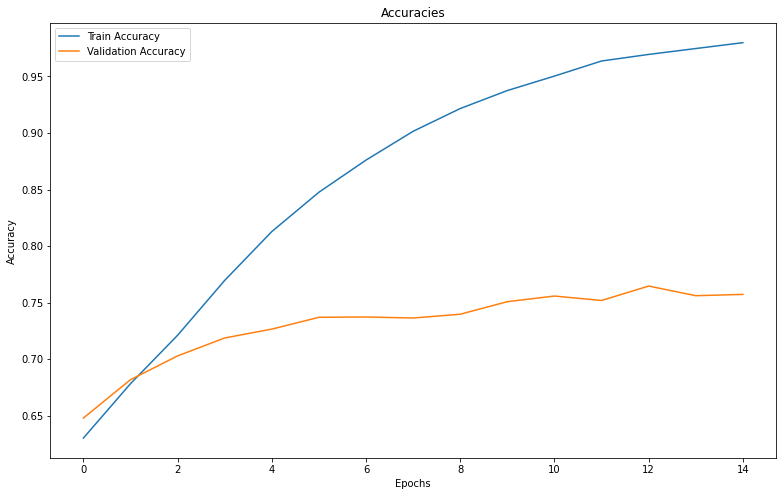

In [43]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc_2"], label = "Train Accuracy")
plt.plot(history.history["val_auc_2"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

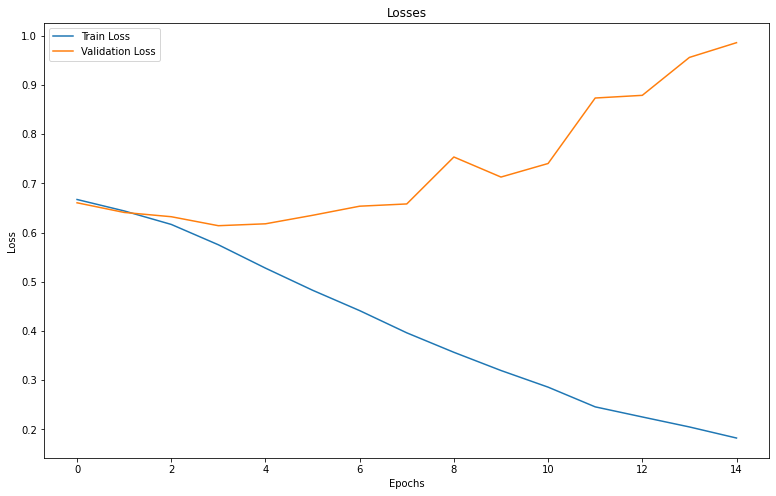

In [44]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###concat

In [45]:
X = np.concatenate([X_FLAIR, X_T1wCE, X_T2w, X_T1w], axis=0)
y = np.concatenate([y_FLAIR, y_T1wCE, y_T2w, y_T1w], axis=0)
train_idt = np.concatenate([train_idt_FLAIR, train_idt_T1wCE, train_idt_T2w, train_idt_T1w], axis=0)

X_test = np.concatenate([X_test_FLAIR, X_test_T1wCE, X_test_T2w, X_test_T1w], axis=0)
test_idt = np.concatenate([test_idt_FLAIR, test_idt_T1wCE, test_idt_T2w, test_idt_T1w], axis=0)

In [46]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X, y, train_idt, test_size=0.1)
# X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
# X_valid = tf.expand_dims(X_valid, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, train_idt_train.shape, train_idt_valid.shape)
## Hyper Parameters
IMAGE_SIZE = 64
N_EPOCHS = 15
N_BATCH = 100
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

(52628, 64, 64) (52628, 2) (5848, 64, 64) (5848, 2) (52628,) (5848,)


In [47]:
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/15
526/526 [==============================] - 8s 12ms/step - loss: 0.6693 - auc_3: 0.6241 - val_loss: 0.6623 - val_auc_3: 0.6460
Epoch 2/15
526/526 [==============================] - 5s 10ms/step - loss: 0.6475 - auc_3: 0.6713 - val_loss: 0.6452 - val_auc_3: 0.6746
Epoch 3/15
526/526 [==============================] - 5s 10ms/step - loss: 0.6210 - auc_3: 0.7117 - val_loss: 0.6436 - val_auc_3: 0.6897
Epoch 4/15
526/526 [==============================] - 5s 10ms/step - loss: 0.5916 - auc_3: 0.7476 - val_loss: 0.6183 - val_auc_3: 0.7175
Epoch 5/15
526/526 [==============================] - 5s 10ms/step - loss: 0.5631 - auc_3: 0.7781 - val_loss: 0.6075 - val_auc_3: 0.7331
Epoch 6/15
526/526 [==============================] - 5s 10ms/step - loss: 0.5340 - auc_3: 0.8056 - val_loss: 0.6068 - val_auc_3: 0.7342
Epoch 7/15
526/526 [==============================] - 5s 10ms/step - loss: 0.5055 - auc_3: 0.8290 - val_loss: 0.6074 - val_auc_3: 0.7432
Epoch 8/15
526/526 [=====================

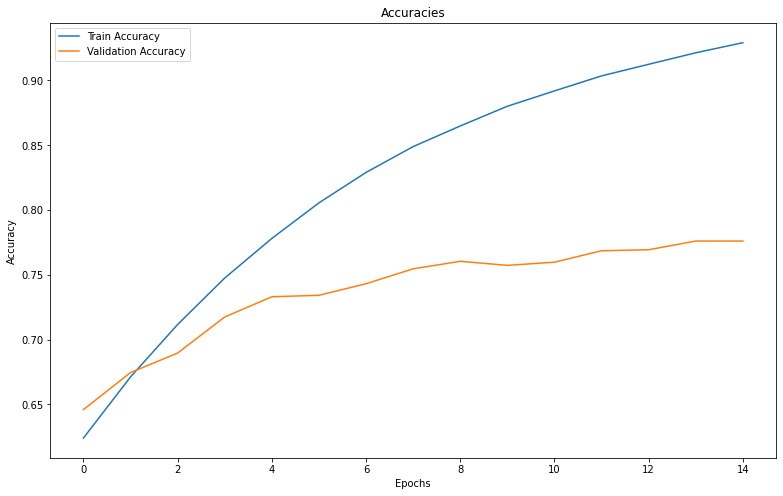

In [48]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc_3"], label = "Train Accuracy")
plt.plot(history.history["val_auc_3"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

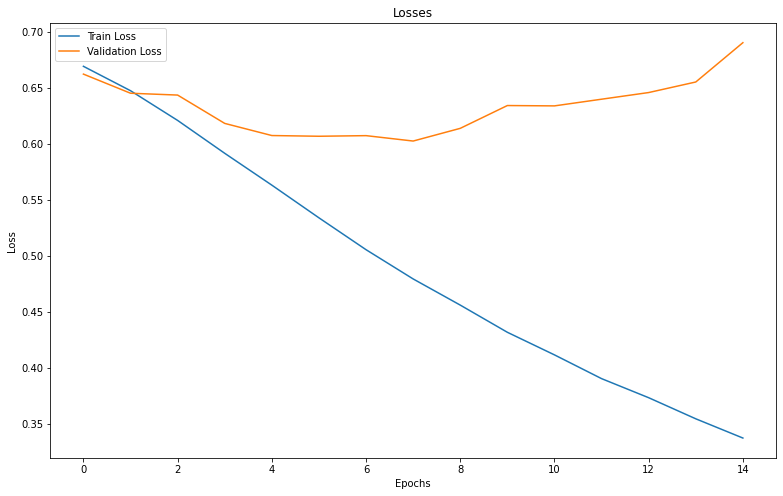

In [49]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()